In [1]:
import json
import math
import os

from pathlib import Path
from typing import Dict, List

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from scipy import stats
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, leaves_list, linkage
from scipy.cluster.vq import vq, kmeans, kmeans2, whiten
from scipy.stats import norm

import mre


## defaults and helper methods

In [57]:
DEFAULT_FIG_HEIGHT = 10


In [3]:
def bhat(mtx1, mtx2):
    return -np.log(np.sum(np.sqrt(mtx1 * mtx2)))

# # code ported from https://github.com/sankalpg/Library_PythonNew
# EPS = np.finfo(np.float).resolution
# def sym_kld(mtx1, mtx2):
#     mtx1 = mtx1 + EPS
#     mtx2 = mtx2 + EPS
#     return mtx1 * np.log(mtx1/mtx2) + mtx2 * np.log(mtx2/mtx1)

In [4]:
def prepare_dataset(
    annotations,
    tdms_files,
    compression_exponent: float = None,  # no compression
    kernel_width: float = None # no smoothing
):
    NUM_BINS = int(1200 / mre.data.TimeDelayedMelodySurface.STEP_SIZE)
    
    num_samples = len(annotations.data)
    num_features = NUM_BINS * NUM_BINS

    # prepare features
    X_3d = np.zeros((NUM_BINS, NUM_BINS, num_samples))
    X_list = list()
    mbids = np.array([])
    for ii, tf in enumerate(tdms_files):
        tdms = mre.data.TDMSFeature.from_json(tf)
        if compression_exponent is not None:
            tdms.compression_exponent = compression_exponent
            tdms.compress()
        if kernel_width is not None:
            tdms.kernel_width = kernel_width
            tdms.smoothen()
        tdms.normalize()
        vals = tdms.embedding

        if vals.size != num_features:
            raise ValueError(
                "%s has %d bins instead of %d."
                % (tf, vals.size, num_features)
            )
        X_3d[:, :, ii] = vals
        X_list.append(vals)
        mbids = np.append(mbids, Path(tf).stem)

    y = annotations.data.set_index("mbid").loc[mbids].makam.values

    return {
        "X_3d": X_3d,  # 48x48x1000
        "X_list": X_list,
        "y": y,
        "mbids": mbids,
        "files": tdms_files,
        "tdms_params": {
            "step_size": tdms.step_size,
            "compression_exponent": tdms.compression_exponent,
            "kernel_width": tdms.kernel_width,
            "time_delay_index": tdms.time_delay_index,
        }
    }


# Read data

## Annotations

In [5]:
annotations = mre.data.Annotation.from_mlflow()
display(annotations.head())

,dunya_uid,makam,mb_url,mbid,observations,tonic,verified
0,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,Acemasiran,http://musicbrainz.org/recording/00f1c6d9-c8ee...,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,,256.0,False
1,168f7c75-84fb-4316-99d7-acabadd3b2e6,Acemasiran,http://musicbrainz.org/recording/168f7c75-84fb...,168f7c75-84fb-4316-99d7-acabadd3b2e6,,115.2,False
2,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,Acemasiran,http://musicbrainz.org/recording/24f549dd-3fa4...,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,,232.5,False
3,407bb0b4-f19b-42ab-8c0a-9f1263126951,Acemasiran,http://musicbrainz.org/recording/407bb0b4-f19b...,407bb0b4-f19b-42ab-8c0a-9f1263126951,,233.5,False
4,443819eb-6092-420c-bd86-d946a0ad6555,Acemasiran,http://musicbrainz.org/recording/443819eb-6092...,443819eb-6092-420c-bd86-d946a0ad6555,,219.6,False


## Time Delayed Melody Surfaces

Below parameters seem optimal for the dataset. 

```
compression_exponent = 0.5
kernel_width = 12.5
time_delay_index = 1.0
```

In [6]:
OPTIMAL_TDMS_PARAMS = { 
    "time_delay_index":1.0,
    "compression_exponent":0.50,
    "kernel_width":12.5,
}

tdms_files = mre.data.TimeDelayedMelodySurface.from_mlflow(
    time_delay_index=OPTIMAL_TDMS_PARAMS["time_delay_index"],
    compression_exponent=None,  # used below
    kernel_width=None  # used below
)


In [7]:
dataset = prepare_dataset(
    annotations,
    tdms_files,
    compression_exponent=OPTIMAL_TDMS_PARAMS["compression_exponent"],
    kernel_width=OPTIMAL_TDMS_PARAMS["kernel_width"]
)
dataset.keys()

dict_keys(['X_3d', 'X_list', 'y', 'mbids', 'files', 'tdms_params'])

# Dendrogram

In [8]:
# this was defined much later (in cluster purity), moved here
LABEL_DICT = {
    'Acemasiran': 'Acemaşiran',          
    'Acemkurdi': 'Acemkürdi',          
    'Bestenigar': 'Bestenigar',          
    'Beyati': 'Beyati',          
    'Hicaz': 'Hicaz',          
    'Hicazkar': 'Hicazkar',          
    'Huseyni': 'Hüseyni',          
    'Huzzam': 'Hüzzam',          
    'Karcigar': 'Karcığar',          
    'Kurdilihicazkar': 'Kürdilihicazkar',          
    'Mahur': 'Mahur',          
    'Muhayyer': 'Muhayyer',          
    'Neva': 'Neva',          
    'Nihavent': 'Nihavent',
    'Rast': 'Rast',          
    'Saba': 'Saba',          
    'Segah': 'Segah',          
    'Sultaniyegah': 'Sultaniyegah',          
    'Suzinak': 'Suzinak',          
    'Ussak': 'Uşşak'
}

In [9]:
def organize_data_by_labels(d_set):
    """Convert the dataset into a dict where makams are the keys
    and features (stored as 3D, 48x48xN ndarray) are the values
    
    We discard the mbid association during this operation
    """
    makam_labels = sorted(set(d_set["y"]))
    
    return {
        lbl: d_set["X_3d"][:, :, d_set["y"]==lbl]
        for lbl in makam_labels
    }

data_by_makams = organize_data_by_labels(dataset)

for val in data_by_makams.values():
    assert val.shape == (48, 48, 50)


In [10]:
def compute_average_tdms_per_makam(
    d_by_makam: Dict[str, np.ndarray]  # 20 keys (makams): 48x48x50 ndarray
) -> Dict[str, np.ndarray]:  # 20 keys (makams): 48x48 ndarray
    return {
        makam: np.mean(data, axis=2)
        for makam, data in data_by_makams.items()
    }

average_tdms_per_makam = compute_average_tdms_per_makam(
    data_by_makams
)


In [71]:
def _flatten_average_tdms_per_makam(
    av_data_by_makam: Dict[str, np.ndarray]  #  20 keys (makams): 48x48 ndarray (feature)
) -> (np.ndarray, np.ndarray):  #  20x48^2 ndarray, 20 makams
    """Convert NxN TDMS feature per makam to MxN^2 required by
    scipy pdist implementation
    """
    flat_mat = np.concatenate(
        [
            data.reshape(1, -1)  # NxN -> 1xN^2 
            for data in av_data_by_makam.values()  # M makams
        ],
        axis=0  # MxN^2 
    )

    return flat_mat, np.array(list(av_data_by_makam.keys()))

def compute_linkage(
    av_tdms_per_makam: Dict[str, np.ndarray]  #  20 keys (makams): 48x48 ndarray (feature)
):
    flat_average_tdms, makam_labels = _flatten_average_tdms_per_makam(
        av_tdms_per_makam
    )
    
    tdms_pdists = pdist(flat_average_tdms, "canberra")
    z = linkage(tdms_pdists, optimal_ordering=True)
    
    return z, makam_labels

def plot_dendogram(z, makam_labels, save_path=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(DEFAULT_FIG_HEIGHT/2, DEFAULT_FIG_HEIGHT))
    
    makam_labels_turkish = np.array([LABEL_DICT[m_lbl] for m_lbl in makam_labels])
    dendrogram(z, labels=makam_labels_turkish, orientation='left', ax=ax)
    ax.set_title('Hierarchical clustering dendrogram for makams\nbased on TDMS distances')
    plt.yticks(weight='bold', size='10')
    plt.tight_layout()
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    
    if save_path is not None:
        plt.savefig(save_path)
    
    # dendograms are plotted in reverse order (first one at the bottom)
    ordered_makam_labels = makam_labels_turkish[leaves_list(z)][::-1]
    
    return ax, ordered_makam_labels   

makam_linkage_wrt_tdms, makam_labels = compute_linkage(average_tdms_per_makam)


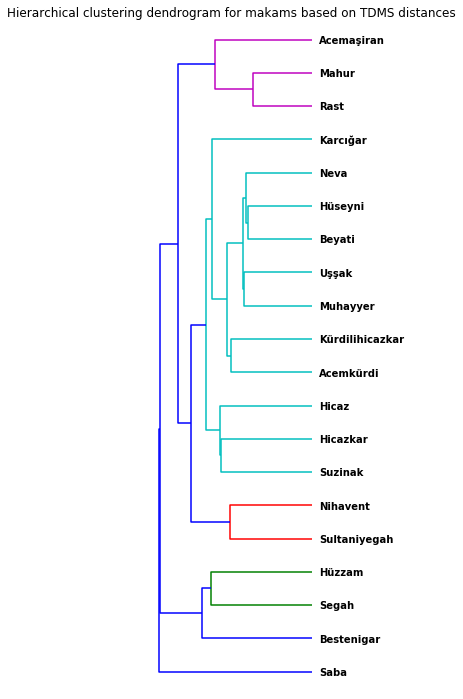

In [59]:
_, ordered_dendogram_labels = plot_dendogram(makam_linkage_wrt_tdms, makam_labels)
plt.show()

In the dendogram, we can observe clusters:

1. Beyati, Hüseyni, Neva, Uşşak & Muhayyer
2. Rast & Mahur
3. Nihavent & Sultaniyegah
4. Hüzzam & Segah

Referring to the confusion matrices, they are also confused by ML models in general.

# Distance matrix

It's not ported from the notebook. I added it as an addition, in case we need it at some point.

Idea: maybe we can plot dist matrix and dendogram together?

In [13]:
def compute_pairwise_dists(
    av_tdms_per_makam: Dict[str, np.ndarray],  #  20 keys (makams): 48x48 ndarray (feature)
    metric="cityblock"
) -> np.ndarray:  # 20x20 ndarray (distance matrix)
    flat_average_tdms, makam_labels = _flatten_average_tdms_per_makam(
        av_tdms_per_makam
    )
    
    pairwise_tdms_dists = cdist(flat_average_tdms, flat_average_tdms, metric)
    
    return pd.DataFrame(
        pairwise_tdms_dists,
        columns=makam_labels,
        index=makam_labels
    )


# Plot pairwise matrix 


In [60]:
def plot_pairwise_df(
    pairwise_df: np.ndarray,
    ordered_labels: np.ndarray = None,
    remove_diag=False,
    remove_yticklabels=False,
    save_path=None,
    ax=None
):
    def lower_tri_masking(A):
        m = A.shape[0]
        r = np.arange(m)
        mask = r[:,None] < r
        return A[mask]

    if ax is None:
        fig, ax = plt.subplots(figsize = (DEFAULT_FIG_HEIGHT, DEFAULT_FIG_HEIGHT))
    
    # order matrix
    if ordered_labels is not None:
        pairwise_df_ordered = pairwise_df[ordered_labels].loc[ordered_labels]
    else:
        pairwise_df_ordered = pairwise_df

    # remove upper triangle from pairwise_df
    if remove_diag:
        mask = np.tril(np.ones(pairwise_df_ordered.shape)).astype(np.bool)
        pairwise_df_tidy = pairwise_df_ordered.where(mask)
        pairwise_df_tidy = pairwise_df_tidy.iloc[1:, :-1]
    else:
        mask = (
            np.tril(np.ones(pairwise_df_ordered.shape)) +
            np.eye(pairwise_df_ordered.shape[0])
        ).astype(np.bool)
        pairwise_df_tidy = pairwise_df_ordered.where(mask)

    sns.heatmap(
        pairwise_df_tidy,
        cmap="gray",
        annot=True,
        annot_kws={"size": 10},
        cbar=False,
        ax=ax,
        yticklabels=not remove_yticklabels
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='left', rotation = -60)
    if not remove_yticklabels:
        ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
    
    if save_path is not None:
        plt.savefig(save_path)


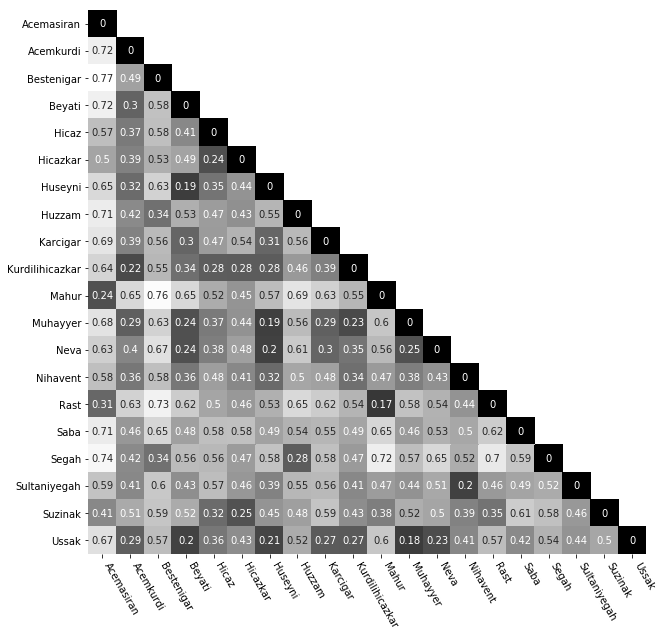

In [61]:
plot_pairwise_df(
    compute_pairwise_dists(average_tdms_per_makam)
)

# Cluster Purity

In [62]:
def cluster_kmeans2(
    tdms_3d: np.ndarray,  # 48x48xN
    num_cluster: int
):
    tdms_3d_shifted = np.moveaxis(tdms_3d, -1, 0)  # Nx48x48; needed for whitening
    tdms_reshaped = tdms_3d_shifted.reshape(tdms_3d_shifted.shape[0], -1)  # Nx48^2

    # original implementation
    centroid, cluster_idx = kmeans2(tdms_reshaped, num_cluster, minit = 'points')

    # # suggested by scipy; the naming convention below hints whitening
    # whitened_tdms = whiten(tdms_reshaped)
    # centroid, cluster_idx = kmeans2(whitened_tdms, num_cluster, minit = 'points')
    
    return cluster_idx.astype(int)

def compute_purity_score(
    cluster_idx: np.ndarray,
    y: np.ndarray
):
    return (
        pd.DataFrame(
            np.c_[(y, cluster_idx)],
            columns=("label", "cluster_id")
        )
        .groupby("cluster_id")
        .aggregate(lambda x: stats.mode(x)[1])
        .sum()
        .iloc[0]
    ) / len(y)

cluster_idx = cluster_kmeans2(dataset["X_3d"], 20)
compute_purity_score(cluster_idx, dataset["y"])


0.475

In [63]:
def compute_pairwise_purity_score(
    tdms_3d: np.ndarray,  # 48x48x100 matrix
    y: np.ndarray,  # label vector of length 1000
    label_dict: Dict[str, str]  # unique makam labels
):
    num_classes = len(label_dict)
    purity_score_mat = np.zeros((num_classes, num_classes))
    
    classes = list(label_dict.keys())
    for ii, cc1 in enumerate(classes):
        # compute triangular instead of full, otherwise the matrix may not be 
        # symetric due to random kmeans2 inits
        # it's also more efficient this way
        for jj, cc2 in enumerate(classes[:ii]):
            slice_bool = np.isin(y, [cc1, cc2])
            tdms_sliced = tdms_3d[:, :, slice_bool]
            y_sliced = y[slice_bool]
            
            cluster_idx = cluster_kmeans2(tdms_sliced, 2)  # pairwise
            purity_score_mat[ii, jj] = compute_purity_score(cluster_idx, y_sliced)
            
            # mirror result; useful for plotting with arbitrariy ordering
            purity_score_mat[jj, ii] = purity_score_mat[ii, jj]

    class_strs = list(label_dict.values())
    return pd.DataFrame(
        purity_score_mat,
        columns=class_strs,
        index=class_strs
    )

pairwise_purity_df = compute_pairwise_purity_score(
    dataset["X_3d"],
    dataset["y"],
    LABEL_DICT
)


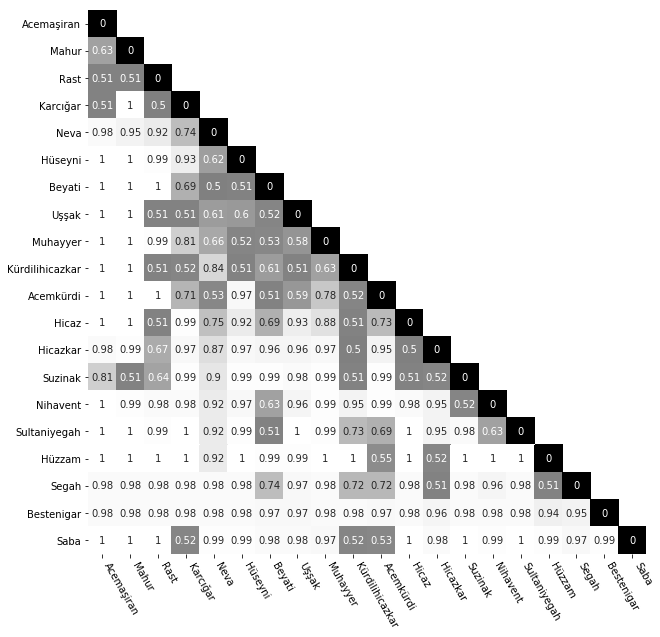

In [64]:
plot_pairwise_df(pairwise_purity_df, ordered_dendogram_labels)


## Merge dendogram & purity scores

Change the order in dist matrix

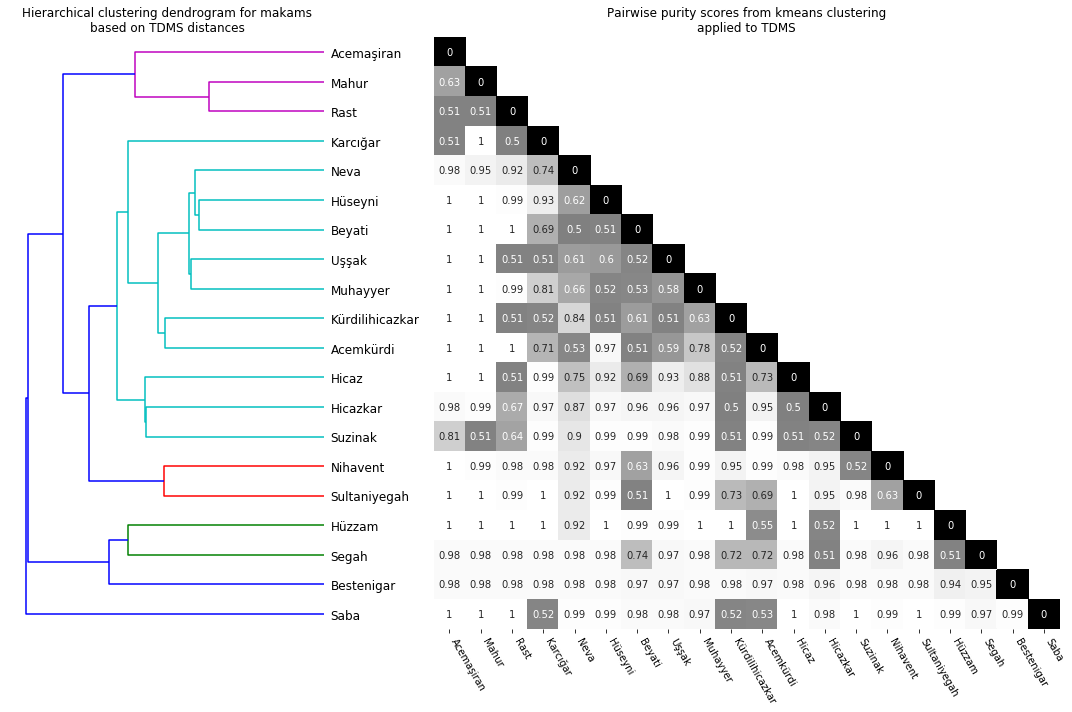

In [72]:
fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(1.5 * DEFAULT_FIG_HEIGHT, DEFAULT_FIG_HEIGHT),
    gridspec_kw={'width_ratios': [1, 2]}
)
_, ordered_dendogram_labels = plot_dendogram(makam_linkage_wrt_tdms, makam_labels, ax=ax1)
plot_pairwise_df(pairwise_purity_df, ordered_dendogram_labels, ax=ax2, remove_yticklabels=True)
ax2.set_title("Pairwise purity scores from kmeans clustering\napplied to TDMS")
plt.tight_layout()
plt.show()

# ROC

In [ ]:
def getDistanceBetweenHist(segment, method, metric, compression = -1):
    cnt = 0

    if method == 1:
        X = np.zeros((len(segment),len(segment)))
        for ii in range(len(segment)):
            for jj in range(len(segment)):
                X[ii,jj] = kldiv(segment[ii],segment[jj])

    if method == 2:
        d = pdist(segment, metric)
        X = squareform(d)

    if method == 3:
        X = np.zeros((len(segment),len(segment)))
        for ii in range(len(segment)):
            for jj in range(len(segment)):
                X[ii,jj] = Bhattacharya(segment[ii],segment[jj])

    if method == 4:
        X = np.zeros((len(segment),len(segment)))
        for ii in range(len(segment)):
            for jj in range(len(segment)):
                X[ii,jj] = jensen_shannon_divergence([segment[ii],segment[jj]])

    rank_order = np.argsort(X)20

    X_norm = X/np.max(X)
    vectorized = np.reshape(X_norm, (len(X_norm)*len(X_norm),1))

    distances = []
    for ii in range(len(X)):
        for jj in range(int(len(X)/2)):
            distances.append(X_norm[jj,ii])

    max_within_class = np.max(distances[int((len(distances)/2)):])
    min_outside_class = np.min(distances[:int((len(distances)/2))])
    dispersion_1 =  min_outside_class / max_within_class

    distances = []
    for ii in range(len(X)):
        for jj in range(int(len(X)/2),len(X)):
            distances.append(X[jj,ii])

    max_within_class = np.max(distances[int((len(distances)/2)):])
    min_outside_class = np.min(distances[:int((len(distances)/2))])
    dispersion_2 =  min_outside_class / max_within_class
    
    dispersion = np.mean((dispersion_1,dispersion_2))

    return dispersion, rank_order, vectorized

In [ ]:
from dit.divergences import jensen_shannon_divergence

def kldiv(x, y):
    eps = np.finfo(float).eps*2*len(x)
    x = np.array(x)+eps
    y = np.array(y)+eps

    if x.size != y.size:
        print ("Arguments are of different length.")
        return np.NaN
    return (np.dot(x, np.log(x)-np.log(y))+np.dot(y, np.log(y)-np.log(x)))


def Bhattacharya(x, y):
    eps = np.finfo(float).eps*2*len(x)
    x = np.array(x)+eps
    y = np.array(y)+eps

    x = x/np.sum(x)
    y = y/np.sum(y)

    return -np.log(np.sum(np.sqrt(x*y)))

In [ ]:
def makeClasses(song_class_1,song_class_2):
    classes_1 = np.hstack([np.ones(song_class_1),np.zeros(song_class_2)]*song_class_1)
    classes_2 = np.hstack([np.zeros(song_class_1),np.ones(song_class_2)]*song_class_2)
    classes = np.hstack((classes_1,classes_2))
    classes = classes.reshape(len(classes),1)
    return classes

classes = makeClasses(50, 50)

from sklearn.metrics import roc_curve, auc

def getBinaryROC(vectorized, classes, label):
    mat = np.append(vectorized,classes,axis=1)
    #print mat

    fpr, tpr, threshold = roc_curve(mat[:,1], mat[:,0], pos_label=0)
    print(threshold)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    print(eer)

    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute micro-average ROC curve and ROC area
    fpr["macro"], tpr["macro"], _ = roc_curve(mat[:,1], mat[:,0], pos_label=0)
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])    

    #plt.figure()
    lw = 2
    plt.plot(fpr["macro"], tpr["macro"], lw=lw, label= label + ', AUC = %0.2f, EER = %0.2f' % ((roc_auc["macro"]-.01), eer))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize = 22)
    plt.ylabel('True Positive Rate',fontsize = 22)
    plt.title('Svara count histogram',fontsize = 18)
    plt.legend(loc="lower right")
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.show()

In [ ]:
import itertools
from scipy.spatial.distance import pdist, squareform
def generateFigureROCFull(data_mat):

    labels = itertools.cycle(('corr', 'eucl', 'ctbl', 'bhat'))

    fig = plt.figure()
    fig.set_size_inches(6,5)
    fig.set_dpi(1200)

    method = 2
    metric = ['correlation', 'euclidean', 'cityblock']

    for ii in metric:
        dispersion, rank_order, vectorized = getDistanceBetweenHist(data_mat, method = method, metric = ii)
        getBinaryROC(vectorized,classes,next(labels))

    method = 3
    dispersion, rank_order, vectorized = getDistanceBetweenHist(data_mat, method = method, metric = 'euclidean')
    getBinaryROC(vectorized,classes,next(labels))

    # plt.show()
    plt.savefig("ROC.png", bbox_inches="tight")

In [ ]:
makam_label_map = {'Mahur':0, 'Acemkurdi':1, 'Nihavent':2, 'Sultaniyegah':3, 'Muhayyer':4, 'Huzzam':5, 'Karcigar':6, 'Saba':7, 'Segah':8, 'Suzinak':9, 'Kurdilihicazkar':10, 'Bestenigar':11, 'Neva':12, 'Hicaz':13, 'Ussak':14, 'Hicazkar':15, 'Huseyni':16, 'Acemasiran':17, 'Beyati':18, 'Rast':19}
makam_number_map = {0: 'Mahur', 1: 'Acemkurdi', 2: 'Nihavent', 3:'Sultaniyegah', 4:'Muhayyer', 5:'Huzzam', 6:'Karcigar', 7:'Saba', 8:'Segah', 9:'Suzinak', 10:'Kurdilihicazkar', 11:'Bestenigar', 12:'Neva', 13:'Hicaz', 14:'Ussak', 15:'Hicazkar', 16:'Huseyni', 17:'Acemasiran', 18:'Beyati', 19:'Rast'}

mahur = []
acem = []

for item in hist_data:
    if (hist_data[item][0][1] == 'Mahur'):
        mahur.append(hist_data[item][0][0])
    if (hist_data[item][0][1] == 'Acemkurdi'):
        acem.append(hist_data[item][0][0])
print(len(mahur), len(acem))

mahur_acem = []
for item in mahur:
    mahur_acem.append(item)
for item in acem:
    mahur_acem.append(item)
    
print(len(mahur_acem))

In [ ]:
generateFigureROCFull(mahur_acem)